d:\face_detection_test\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 381 files in data\300W\test


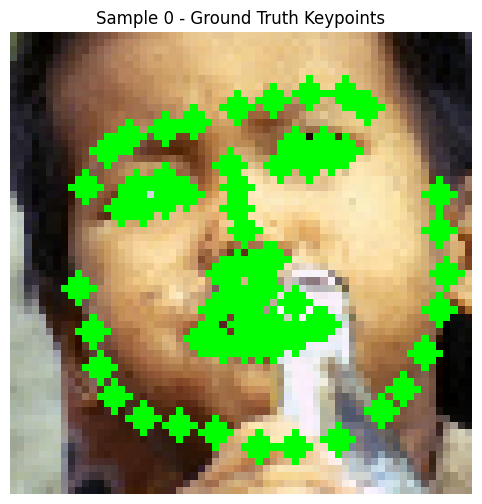

Saved sample image 0 to output_images\sample_0.png


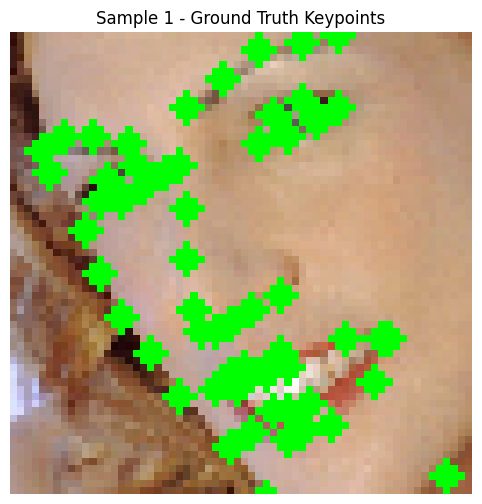

Saved sample image 1 to output_images\sample_1.png


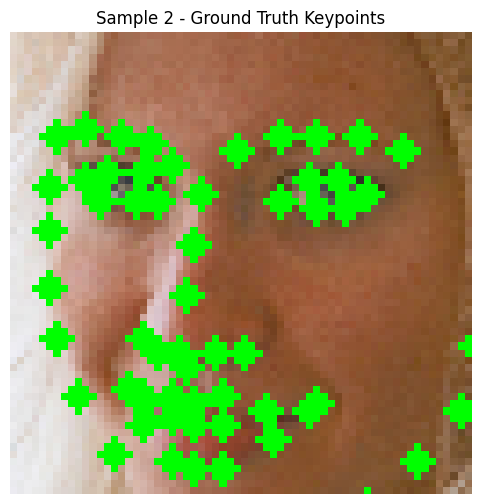

Saved sample image 2 to output_images\sample_2.png


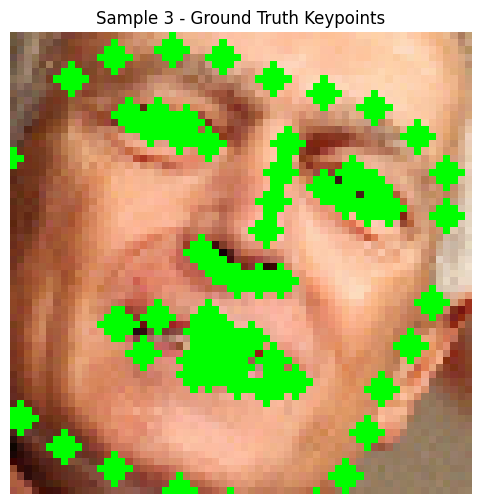

Saved sample image 3 to output_images\sample_3.png


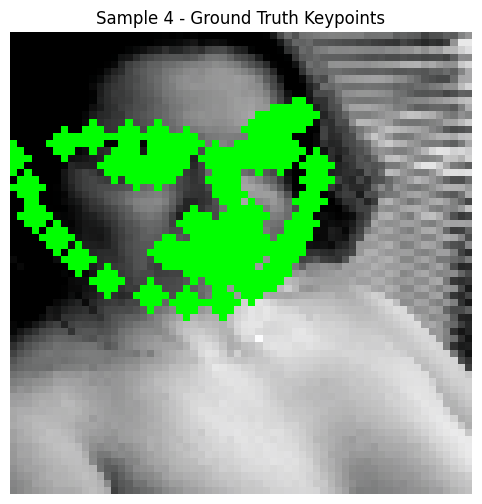

Saved sample image 4 to output_images\sample_4.png


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from pathlib import Path
from dataset import FaceLandmarksDataset, get_files
import config

def draw_keypoints(image, landmarks, color=(0, 255, 0), radius=2, thickness=-1):
    """
    Draw keypoints on an image.
    
    Args:
        image (np.ndarray): Image in RGB format.
        landmarks (np.ndarray): Array of shape (N, 2) with keypoints.
        color (tuple): Color of keypoints (default green).
        radius (int): Circle radius.
        thickness (int): Thickness (-1 fills the circle).
        
    Returns:
        np.ndarray: Image with drawn keypoints.
    """
    image_out = image.copy()
    for (x, y) in landmarks:
        cv2.circle(image_out, (int(x), int(y)), radius, color, thickness)
    return image_out

def denormalize_image(image_tensor):
    """
    Denormalize a tensor image using the standard ImageNet means and stds.
    The input image_tensor is assumed to be in [C, H, W] format.
    
    Returns:
        np.ndarray: Denormalized image in [H, W, C] format (uint8, 0-255).
    """
    # Convert tensor to numpy array in HWC format.
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    # Denormalize assuming ImageNet parameters (adjust if needed)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    return image

test_folder = list(config.TEST_FOLDERS.values())[0]
files = get_files([test_folder])
print(f"Found {len(files)} files in {test_folder}")

dataset = FaceLandmarksDataset(files, train=False)

num_samples = 5  # Display first 5 samples
output_dir = Path("output_images")
output_dir.mkdir(exist_ok=True)

for idx in range(min(num_samples, len(dataset))):
    sample = dataset[idx]
    # Get image tensor (C, H, W) and convert to HWC numpy array
    image_tensor = sample["image"]
    image_denorm = denormalize_image(image_tensor)
    
    # Get ground truth landmarks (in transformed image coordinates)
    landmarks = sample["landmarks"].cpu().numpy()  # shape: (68, 2)
    
    # Draw keypoints on the image
    image_with_keypoints = draw_keypoints(image_denorm, landmarks, color=(0, 255, 0), radius=2, thickness=-1)
    
    # Display the image using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(image_with_keypoints)
    plt.title(f"Sample {idx} - Ground Truth Keypoints")
    plt.axis('off')
    plt.show()
    
    # Optionally, save the image
    output_path = output_dir / f"sample_{idx}.png"
    # Convert RGB image to BGR for cv2.imwrite
    cv2.imwrite(str(output_path), cv2.cvtColor(image_with_keypoints, cv2.COLOR_RGB2BGR))
    print(f"Saved sample image {idx} to {output_path}")
